### Import data

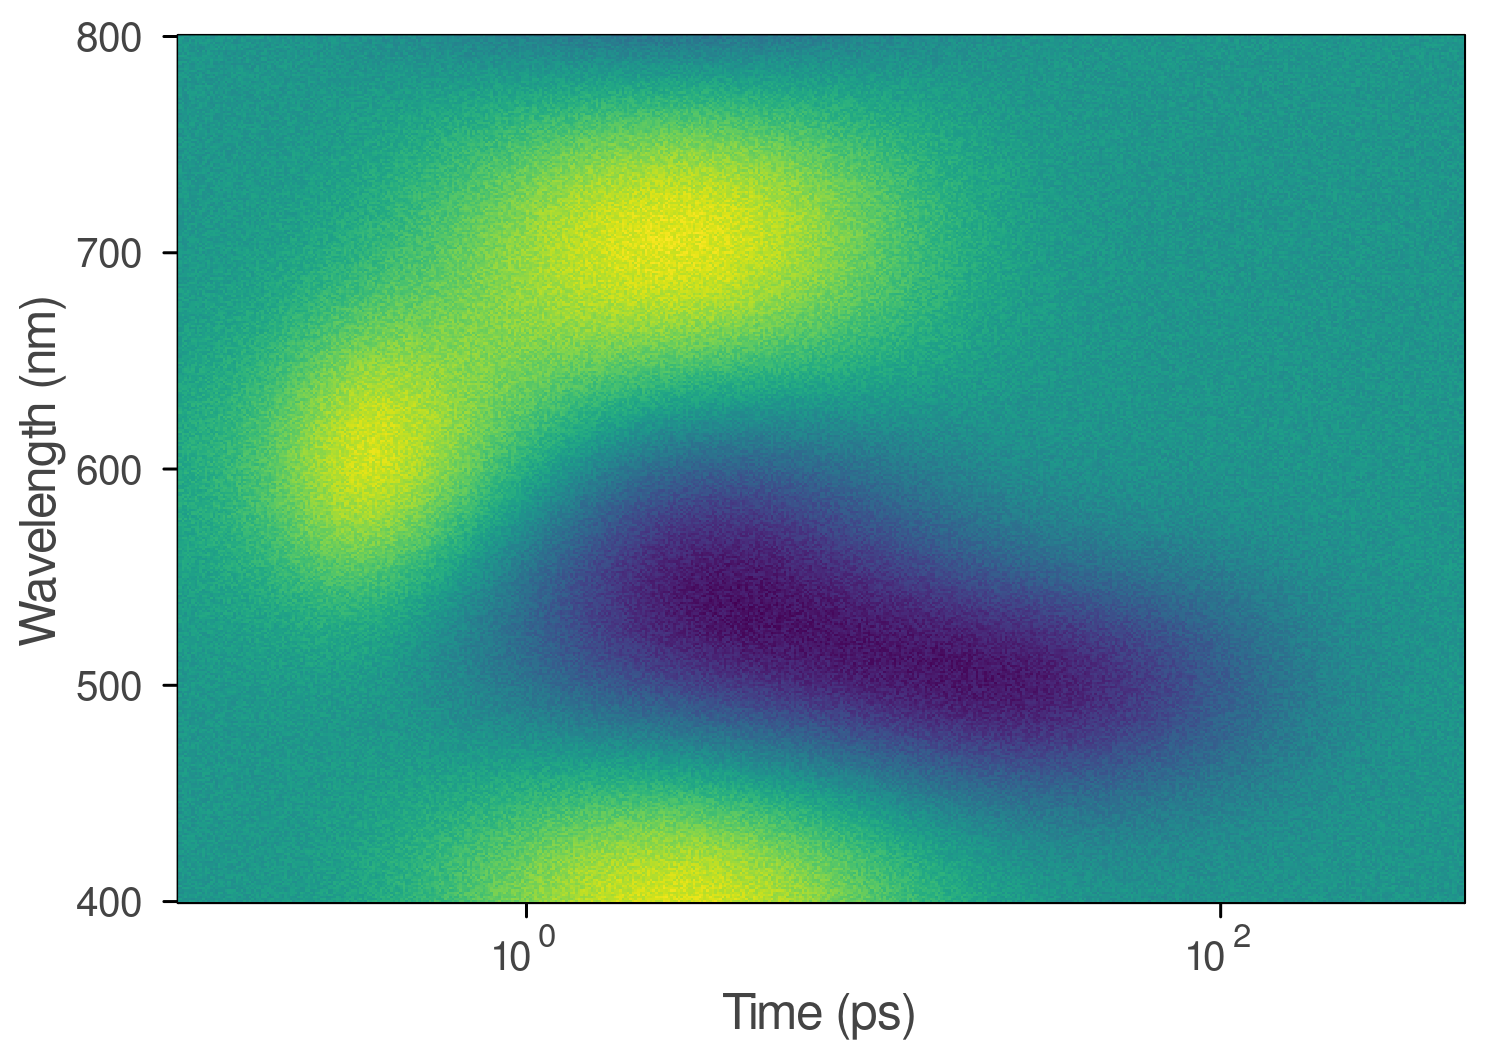

In [418]:
include("../src/DataImport.jl")
include("../src/plots.jl")

# define .csv file containing experimental data
# file = raw"C:\Data\testdat_first_order_seq.csv"
file = joinpath("..", "data", "testData_first_order_seq.csv")

# import data
data = importData(file)[1]
# spectral dimension
s = data.x
# time dimension
t = data.y
# 2D data
d = data.z

# plot dataset for quick overview
tBl = t .> 0
heatmap(t[tBl], s, d[:,tBl], xscale=:log10, c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")


### Define kinetic model

In [419]:
include("../src/kinetic.jl")

# define kinetic model
rn = @reaction_network begin
    k1, A --> B
    k2, B --> C
    k3, C --> 0
end

# define starting values and bounds for the parameter optimization 
limits = Dict(
    :A => 1,
    :B => 0,
    :C => 0,
    :k1 => [5e-1, 5],
    :k2 => [5e-2, 5e-1],
    :k3 => [5e-3, 5e-2],
    :μ => [-0.5, 0.5],
    :σ => [0.04, 0.2]
)

# show reaction network
using Latexify
latexify(rn)

L"\begin{align*}
\mathrm{A} &\xrightarrow{k1} \mathrm{B} \\
\mathrm{B} &\xrightarrow{k2} \mathrm{C} \\
\mathrm{C} &\xrightarrow{k3} \varnothing  
 \end{align*}
"

### Run the optimization

In [420]:
# maximum number of iterations
maxIter = 200

# generate bounds for fit parameters
bounds = generateBoundsMH(rn, limits)

# run optimization
using Metaheuristics
options = Options(iterations=maxIter, parallel_evaluation=true, store_convergence=true)
result = Metaheuristics.optimize((param)->simulateDataParallel(t, rn, param, limits, d),
    bounds, DE(N=10;options))

Optimization Result
===================
  Iteration:       200
  Minimum:         590.236
  Minimizer:       [0.997339, 0.100349, 0.0100013, …, 0.0996734]
  Function calls:  2000
  Total time:      5.9640 s
  Stop reason:     Maximum number of iterations exceeded.

### Monitor fit convergence
You can increase `maxIter` if there is no clear convergence.

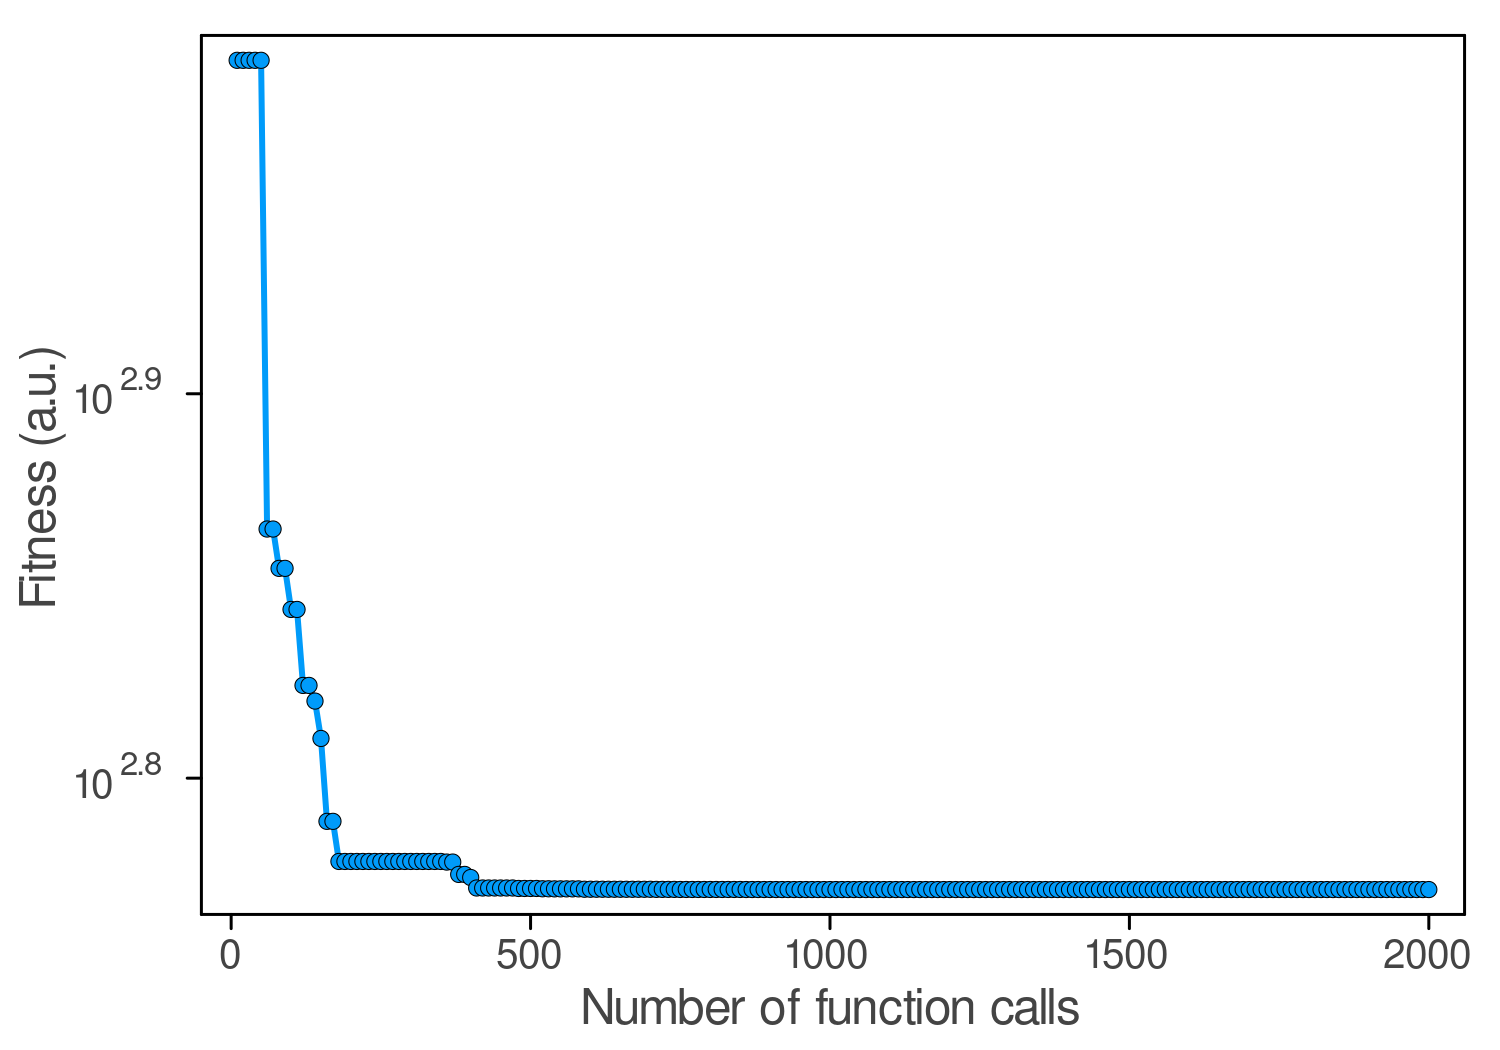

In [421]:
plot(convergence(result)..., xlabel="Number of function calls", ylabel="Fitness (a.u.)",
    marker=:circle, ms=3, msw=0.5, yscale=:log10)

### Get optimized parameters and fit data

In [422]:
# get optimized parameters
fitParam = minimizer(result)



5-element Vector{Float64}:
 0.9973390662322911
 0.1003486294664466
 0.01000126028464926
 0.19956653319951173
 0.09967336904547863

In [423]:
# get best fit data
fitData, fitSpc, fitKin = simulateData(t, rn, fitParam, limits, d; ret="kin")

([0.0 0.0 … -0.0003315164294693306 -0.0003045857496198111; 0.0 0.0 … -0.0004270147839909692 -0.00039232631181756707; … ; 0.0 0.0 … -2.681872562432353e-5 -2.464011108350921e-5; 0.0 0.0 … -3.503828818568827e-5 -3.219195890084892e-5], [0.0018852095726328779 0.9772124701894633 -0.04054221359159208; -0.006872288592444353 0.9956537600213716 -0.05222101543215078; … ; 0.009671346903890642 -0.2748755563332513 -0.003279748470554261; -0.005114273843055532 -0.29087461560072114 -0.004284945291495327], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 1.1198506675542855e-18 -1.2451315824791238e-18 0.008177067804163548; 7.731040428596452e-19 -8.595933099932541e-19 0.007512805114395069])

### Plot optimized kinetics

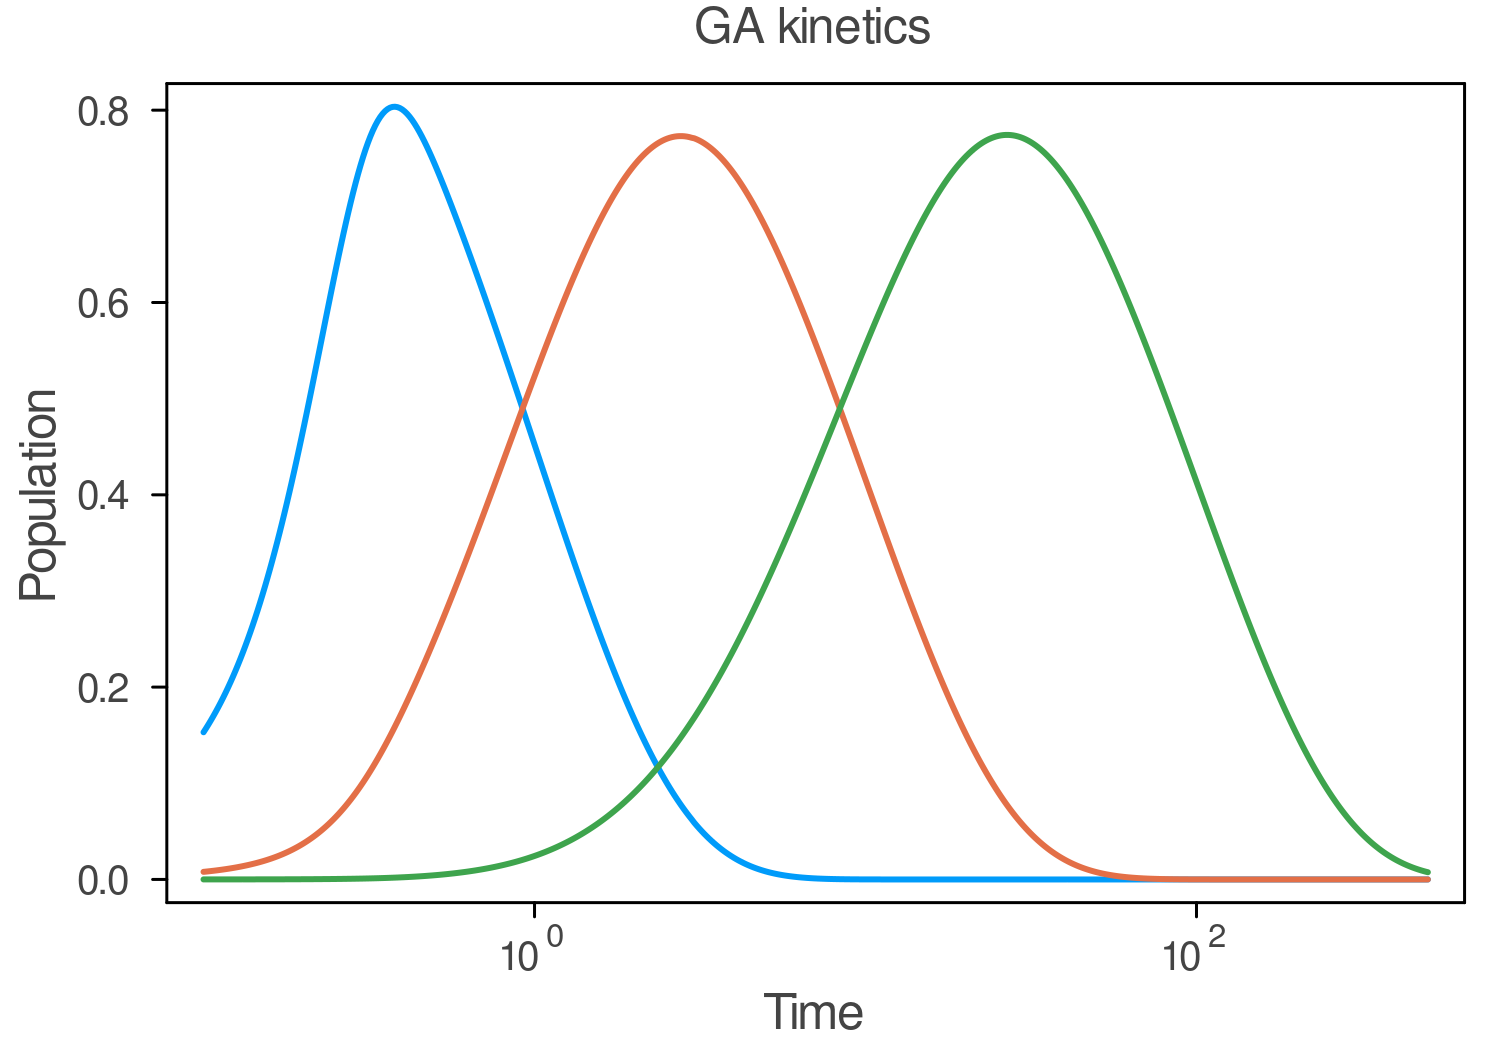

In [424]:
# positive times for log plot
tBl = t .> 0

# plot kinetics
plot(t[tBl], fitKin[tBl,:], xscale=:log10, title="GA kinetics", 
xlabel="Time", ylabel="Population")

### Plot optimized spectral signatures

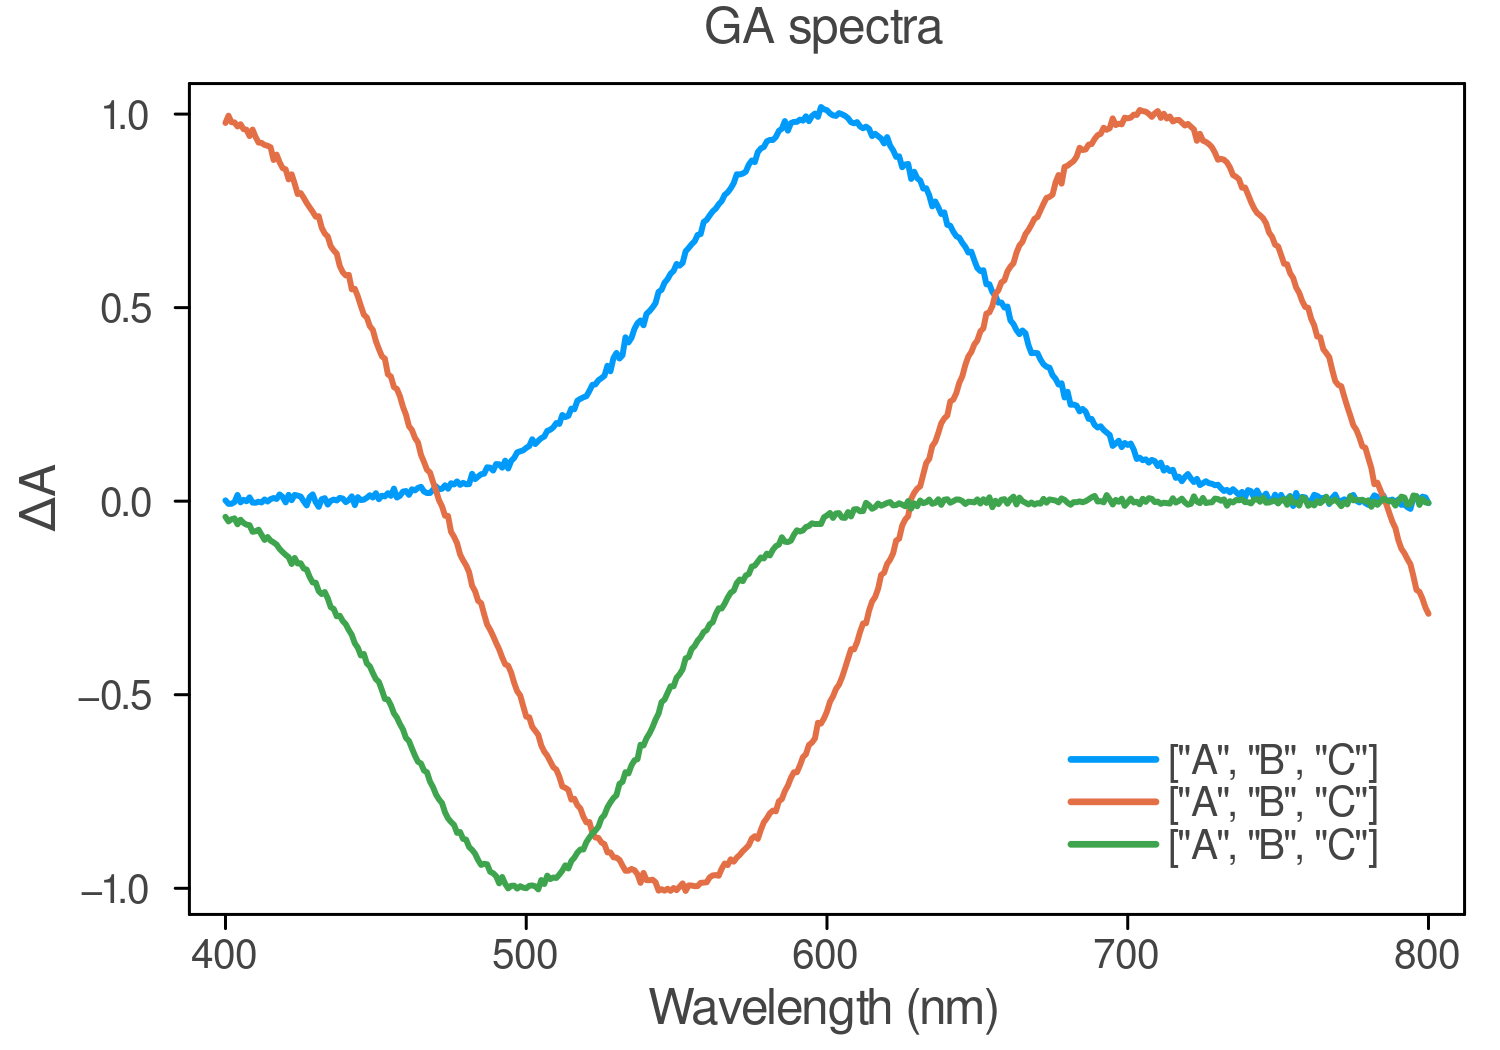

In [425]:
plot(s, fitSpc, title="GA spectra", 
xlabel="Wavelength (nm)", ylabel="ΔA", label=string.(getSpecies(rn)), legend=true)

### Plot fit residuals

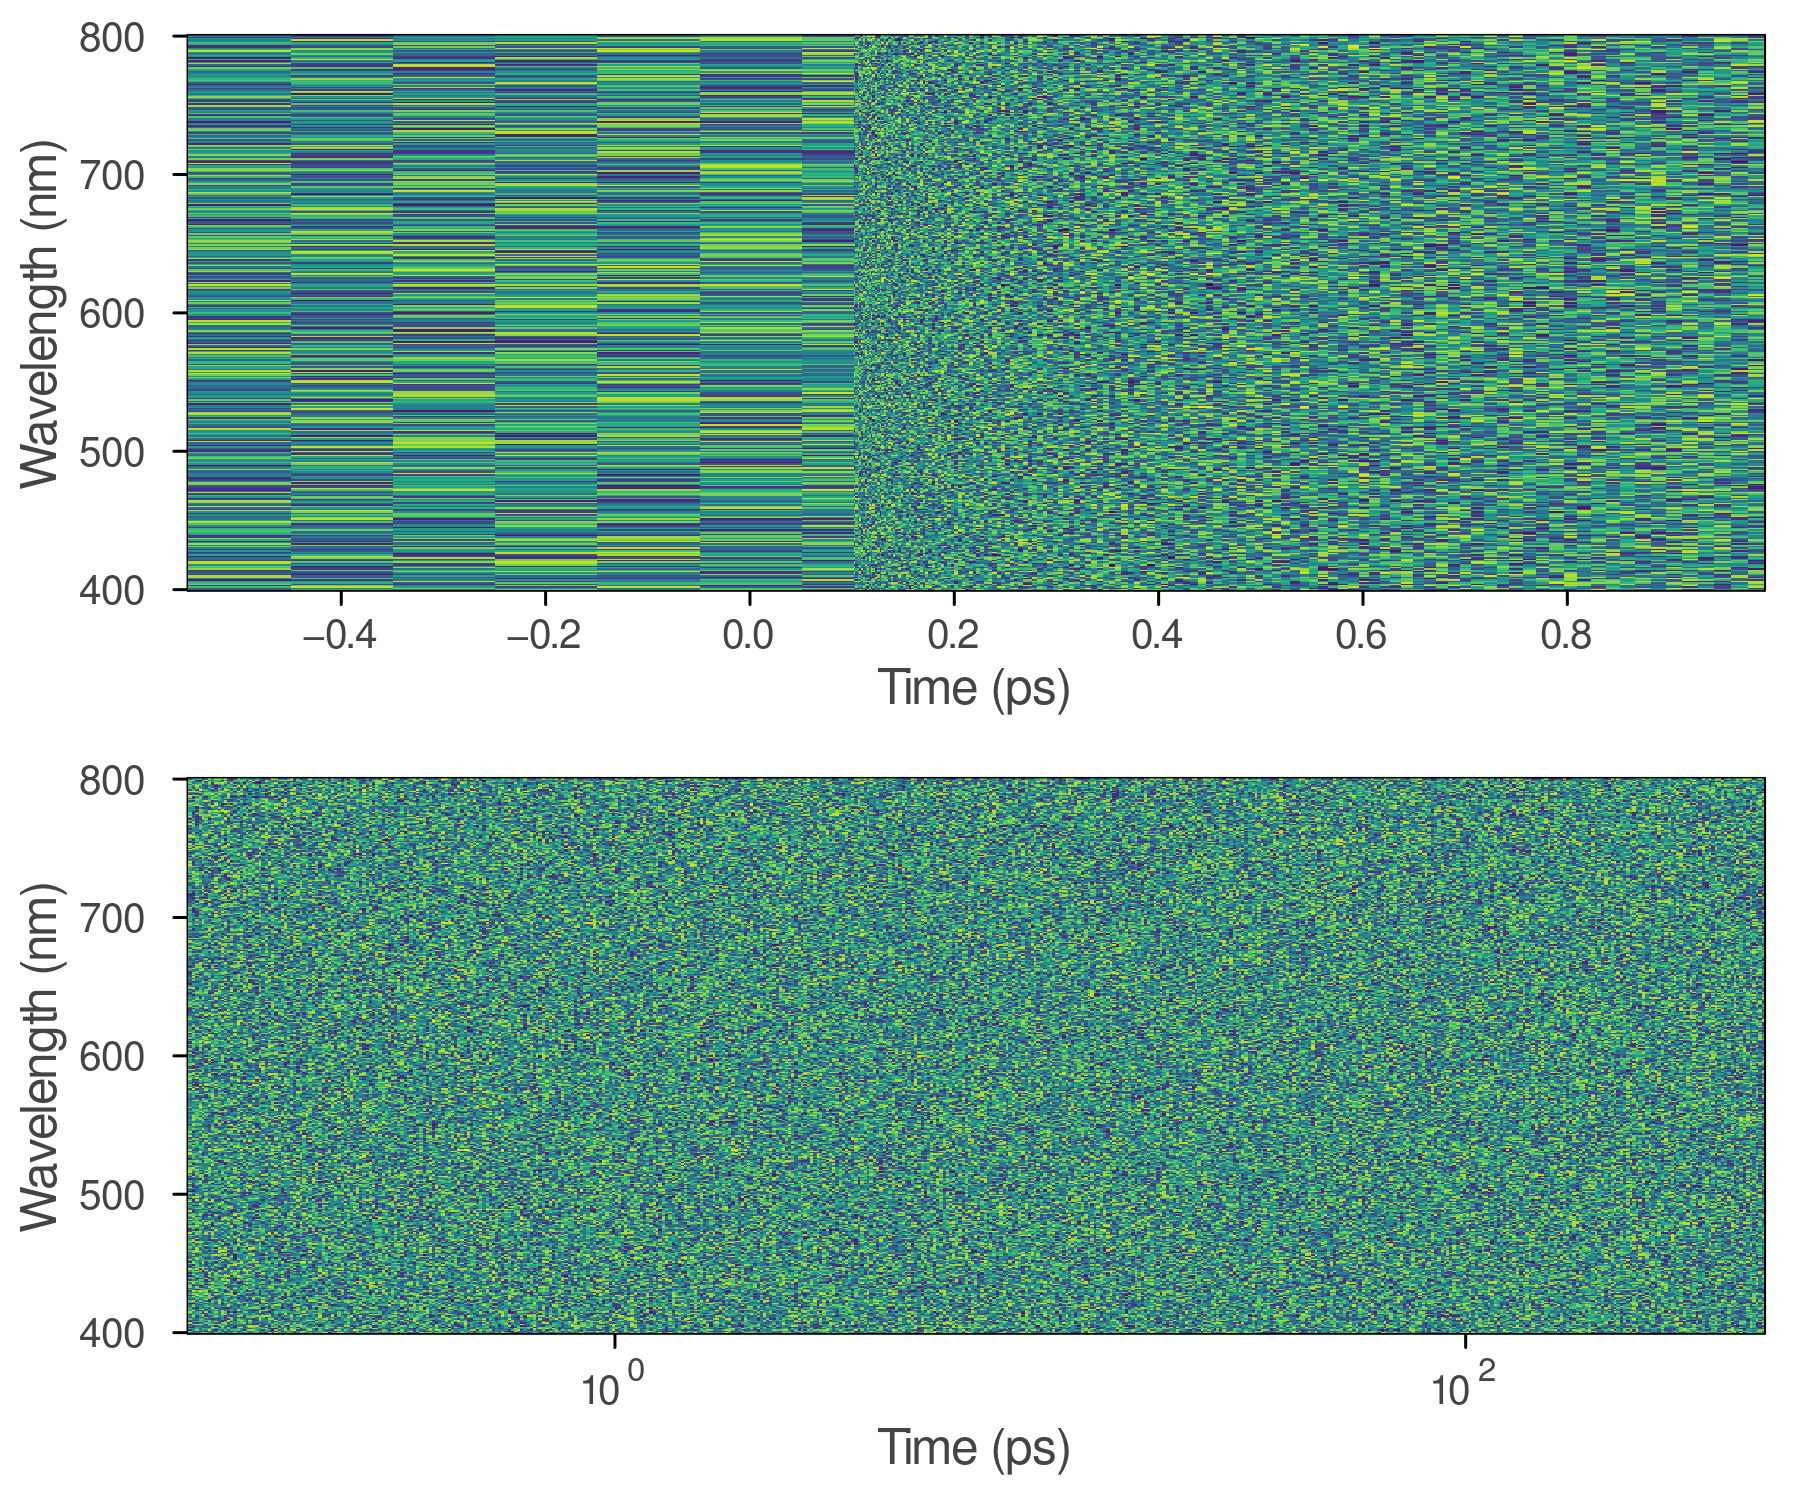

In [426]:
# linear plot around t = 0
tBl = -0.5 .≤ t .≤ 1
p1 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")

# log plot at positive times
tBl = t .> 0
p2 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xscale=:log10, xlabel="Time (ps)", ylabel="Wavelength (nm)")

# combine plots
plot(p1,p2, layout=(2,1), size=(600,500))